# Analysis of Real Estate Prices and Features in King County, Seattle 

## Overview

Recommendations:

- 1
- 2
- 3

## Business Problem

A real estate agency is looking to provide advice to homeowners looking to increase the values of their homes. We are seeking to identify several variables that can **predict** what a home's sale price can be.

**Alternately:** If a customer is looking to purchase land without a house already on the lot, our recommendations will help home builders maximize their profits by helping builders identify which predictor variables to focus on.

## Importing Packages and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import sklearn.metrics as metrics

# from random import gauss
# from mpl_toolkits.mplot3d import Axes3D

from statsmodels.formula.api import ols
import statsmodels.api as sm

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split

%matplotlib inline

...and some formatting options.

In [2]:
# Shows *all* columns in dataframe, i.e. does not truncate horizontally
pd.set_option('display.max_columns', None)

# Converts from scientific notation to standard form (applied to every df in
# this notebook) and rounds to two decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Below, we read in the data and check out some of its basic features: column names, null values, data types, etc.

In [3]:
df = pd.read_csv('./data/kc_house_data.csv')

# Listing out column names
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [4]:
# Checking out descriptive statistics
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,17755.00,21597.00,21597.00,21597.00,21597.00,21597.00
mean,4580474287.77,540296.57,3.37,2.12,2080.32,15099.41,1.49,1788.60,1971.00,83.64,98077.95,47.56,-122.21,1986.62,12758.28
std,2876735715.75,367368.14,0.93,0.77,918.11,41412.64,0.54,827.76,29.38,399.95,53.51,0.14,0.14,685.23,27274.44
min,1000102.00,78000.00,1.00,0.50,370.00,520.00,1.00,370.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,2123049175.00,322000.00,3.00,1.75,1430.00,5040.00,1.00,1190.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,1.50,1560.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,7308900490.00,645000.00,4.00,2.50,2550.00,10685.00,2.00,2210.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,9410.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


## Splitting data into train and test sets

Our **target** variable, or `X`, is going to be `price`, i.e. the sale price of a given home.

In [5]:
# Creating target variable and predictor dataframe
y = df['price']
X = df.drop(labels = 'price',
            axis = 1)

In [6]:
# Initiating train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [7]:
print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns.")
print(f"y_train is a Series with {y_train.shape[0]} values.")

assert X_train.shape[0] == y_train.shape[0]

X_train is a DataFrame with 14469 rows and 20 columns.
y_train is a Series with 14469 values.


## Initial Cleaning

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14469 entries, 19709 to 15795
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             14469 non-null  int64  
 1   date           14469 non-null  object 
 2   bedrooms       14469 non-null  int64  
 3   bathrooms      14469 non-null  float64
 4   sqft_living    14469 non-null  int64  
 5   sqft_lot       14469 non-null  int64  
 6   floors         14469 non-null  float64
 7   waterfront     12913 non-null  object 
 8   view           14427 non-null  object 
 9   condition      14469 non-null  object 
 10  grade          14469 non-null  object 
 11  sqft_above     14469 non-null  int64  
 12  sqft_basement  14469 non-null  object 
 13  yr_built       14469 non-null  int64  
 14  yr_renovated   11883 non-null  float64
 15  zipcode        14469 non-null  int64  
 16  lat            14469 non-null  float64
 17  long           14469 non-null  float64
 18  sq

Right away, we notice some columns with null values:
- `waterfront`
- `view`
- `yr_renovated`

We'll have to either figure out how to fill in those null values or drop them altogether.

Since we have a fairly small number of null values in the `view` column (63 entries in total), we can safely *drop* those rows.

In [9]:
X_train.shape

(14469, 20)

In [10]:
X_test.shape

(7128, 20)

In [11]:
df_copy = df.copy()

In [12]:
df_copy['id'].value_counts()

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

When we run `value_counts()` on the `id` column, we discover that some `id` values appear multiple times in the dataset - these represent houses that have **multiple sales** on record. The code below creates a new version of `df_copy` that retains only the **most recent sale** for given `id`.

In [13]:
# Dropping rows where `id` is repeated
# df_copy = df_copy.sort_values(by=['id', 'date'])
# df_copy = df_copy.drop_duplicates(subset=['id'], keep='last')

The column `date` is read in as datatype `object`, but we can convert it into datetime format with a single line of code for easier use.

In [14]:
# Converting column `date` to datetime64[ns] from type string/object
# df['date'] = df['date'].astype('datetime64[ns]')

In [15]:
# Creating variables to count values in columns `grade`, `condition`, 
# and `yr_renovated` in King County real estate data train set

view_counts = X_train['view'].value_counts()
grade_counts = X_train['grade'].value_counts()
condition_counts = X_train['condition'].value_counts()
renovation_counts = X_train['yr_renovated'].value_counts()

# Looping through to see several value counts at once
counts = [view_counts, grade_counts, condition_counts, renovation_counts]
num = 0

for x in counts:
    num += 1
    column_name = x.name
    print(f"'{column_name.upper()}' value counts:\n{x}\n\n")

'VIEW' value counts:
NONE         13023
AVERAGE        626
GOOD           335
EXCELLENT      225
FAIR           218
Name: view, dtype: int64


'GRADE' value counts:
7 Average        6002
8 Good           4096
9 Better         1725
6 Low Average    1355
10 Very Good      769
11 Excellent      270
5 Fair            166
12 Luxury          62
4 Low              16
13 Mansion          7
3 Poor              1
Name: grade, dtype: int64


'CONDITION' value counts:
Average      9406
Good         3775
Very Good    1153
Fair          118
Poor           17
Name: condition, dtype: int64


'YR_RENOVATED' value counts:
0.00       11390
2014.00       43
2005.00       24
2007.00       23
2003.00       22
           ...  
1974.00        1
1956.00        1
1944.00        1
1951.00        1
1946.00        1
Name: yr_renovated, Length: 66, dtype: int64




In [16]:
# Dropping nulls from column `view`
X_train = X_train.dropna(subset = ['view'])

# Filling null values in column `view` with string indicating
# that no record exists on the property's view
# X_train.view.fillna(value = 'NO_RECORD', inplace = True)

# Filling null values in column `yr_renovated` with integer 0,
# indicating that no renovation year exists for this record
# X_train.yr_renovated.fillna(value = 0, inplace = True)

## Exploring Data

In [17]:
#looking at correlations
#fig, ax = plt.subplots(figsize=(15,15))
#heat = sns.heatmap(df_copy.corr(), annot = True)

Observations from this heatmap:

- We'll likely need to use a **mask** on this heatmap in order to create a more readable visualization that focuses on relevant features/columns.
- `sqft_living` has the highest correlation with price...
    - ...but `sqft_living` is also correlated with several other columns: `sqft_living15`, `sqft_above`, `bathrooms`, and `bedrooms`, so we'll likely need to choose just one of these features in order to minimize multicollinearity.
- `zipcode`, `lat`, and `long` all have low (0.31 or below) correlations with `price` - these columns likely won't be useful to us in constructing models for this project, but could be worth looking into as next-step recommendations.

Below, we group the dataset by column `view` and get some descriptive statistics on the column.

In [18]:
df_copy.groupby('view').mean()

df_copy.sort_values('price', ascending = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,7700000.00,6,8.00,12050,27600,2.50,NO,GOOD,Good,13 Mansion,8570,3480.0,1910,1987.00,98102,47.63,-122.32,3940,8800
3910,9808700762,6/11/2014,7060000.00,5,4.50,10040,37325,2.00,YES,AVERAGE,Average,11 Excellent,7680,2360.0,1940,2001.00,98004,47.65,-122.21,3930,25449
9245,9208900037,9/19/2014,6890000.00,6,7.75,9890,31374,2.00,NO,EXCELLENT,Average,13 Mansion,8860,1030.0,2001,0.00,98039,47.63,-122.24,4540,42730
4407,2470100110,8/4/2014,5570000.00,5,5.75,9200,35069,2.00,NO,NONE,Average,13 Mansion,6200,3000.0,2001,nan,98039,47.63,-122.23,3560,24345
1446,8907500070,4/13/2015,5350000.00,5,5.00,8000,23985,2.00,NO,EXCELLENT,Average,12 Luxury,6720,1280.0,2009,0.00,98004,47.62,-122.22,4600,21750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2139,1623049041,5/8/2014,82500.00,2,1.00,520,22334,1.00,NO,NONE,Fair,5 Fair,520,0.0,1951,0.00,98168,47.48,-122.30,1572,10570
8267,3883800011,11/5/2014,82000.00,3,1.00,860,10426,1.00,NO,NONE,Average,6 Low Average,860,0.0,1954,0.00,98146,47.50,-122.34,1140,11250
16184,3028200080,3/24/2015,81000.00,2,1.00,730,9975,1.00,NaN,NONE,Poor,5 Fair,730,0.0,1943,0.00,98168,47.48,-122.31,860,9000
465,8658300340,5/23/2014,80000.00,1,0.75,430,5050,1.00,NaN,NONE,Fair,4 Low,430,0.0,1912,0.00,98014,47.65,-121.91,1200,7500


Visually the price of average, fair and good look the about the same so we would need to run a significance test and visualize the data to see. Excellent and none looks to be potentially significant. Need to use anova here to see and ad-hoc tests

In [19]:
# Dropping irrelevant columns
df_copy.drop(columns = ['id', 'floors', 'waterfront',
                        'bathrooms', 'bedrooms',
                        'lat', 'long',
                        'yr_built', 'yr_renovated', 
                        'sqft_lot', 'sqft_lot15',
                        'sqft_above', 'sqft_living15',
                        'zipcode', 'sqft_basement'],
                        inplace=True, axis=1 )

In [20]:
df_copy.head()

,date,price,sqft_living,view,condition,grade
0,10/13/2014,221900.00,1180,NONE,Average,7 Average
1,12/9/2014,538000.00,2570,NONE,Average,7 Average
2,2/25/2015,180000.00,770,NONE,Average,6 Low Average
3,12/9/2014,604000.00,1960,NONE,Very Good,7 Average
4,2/18/2015,510000.00,1680,NONE,Average,8 Good


In [21]:
# df_copy['grade'].value_counts()

In [22]:
# fig, ax = plt.subplots(figsize=(20,10))

# sns.histplot(df_copy['grade'])

### Initiating `train_test_split`

In [23]:
# Establishing target and predictor variables
X = df_copy.drop(columns = 'price')
y = df_copy.price

In [24]:
# Creating variables for train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
train_df = pd.concat([X_train, y_train], axis=1)

test_df = pd.concat([X_test, y_test], axis=1)

In [26]:
# fig, ax = plt.subplots(figsize=(8,8))
# heat = sns.heatmap(train_df.corr(), annot = True)

### View Analysis

is there a difference between those that have a view versus those that don't

In [27]:
summary_of_view = df_copy.groupby('view').agg(['mean', 'std'])

summary_of_view

price           sqft_living        
                mean       std        mean     std
view                                              
AVERAGE    791390.37 510385.69     2650.72 1133.09
EXCELLENT 1452465.88 930747.70     3334.48 1539.56
FAIR       813373.27 512776.63     2571.05 1042.26
GOOD       973285.20 613898.40     3016.85 1204.90
NONE       496806.07 287419.96     1998.36  836.49

Observations from this summary:

- Significant gap between `EXCELLENT` and `GOOD`
- Smallest gap is between `FAIR` and `AVERAGE` - we'll need to determine if this difference is a signficant one.

From the df summary, we notice that there is a difference in price between price for those that are excellent
compared to those that have a view written as none. Further investigation will be performed to determine if this
difference is statistically significant

In [28]:
# Figure out how to do this in a loop/function?
df_average = train_df[train_df['view'] == 'AVERAGE']
df_excellent = train_df[train_df['view'] == 'EXCELLENT']
df_fair = train_df[train_df['view'] == 'FAIR']
df_good = train_df[train_df['view'] == 'GOOD']
df_none = train_df[train_df['view'] == 'NONE']

In [29]:
train_df['view'].value_counts()

NONE         13023
AVERAGE        626
GOOD           335
EXCELLENT      225
FAIR           218
Name: view, dtype: int64

Subsetting the data into different views
 - Number of rows:
     - `NONE` = 12906
     - `AVERAGE` = 636
     - `GOOD` = 342
     - `FAIR` = 213
     - `EXCELLENT` = 212

In [30]:
fvalue, pvalue = stats.f_oneway(df_average['price'], df_excellent['price'], df_fair['price'],
                                df_good['price'] , df_none['price'])

In [31]:
#creating df of just view
# df_view = train_df[['view', 'price']]

#Tukey test
#print(pairwise_tukeyhsd(df_view['price'], df_view['view']))

`AVERAGE` and `FAIR` are not significant to each other, so they should be grouped together. Each other subset should be on their own as they have a p value of < .05

#### Grade Analysis

 Is there a difference between grades

In [32]:
train_df.grade.value_counts()

7 Average        6002
8 Good           4096
9 Better         1725
6 Low Average    1355
10 Very Good      769
11 Excellent      270
5 Fair            166
12 Luxury          62
4 Low              16
13 Mansion          7
3 Poor              1
Name: grade, dtype: int64

Issues that may be present here:
- Only a single record for `grade` value of `3 Poor`
- `grade` is type `object`, so we'll need to convert it in the encoding process.

In [85]:
# Dropping poor row, since there is only one
df3 = train_df.copy()
df3 = df3[df3['grade'] != '3 Poor']

In [87]:
df3.grade = [x.replace(" ", "_").strip() for x in df3.grade]

In [90]:
df3['grade'].value_counts()

7_Average        6002
8_Good           4096
9_Better         1725
6_Low_Average    1355
10_Very_Good      769
11_Excellent      270
5_Fair            166
12_Luxury          62
4_Low              16
13_Mansion          7
Name: grade, dtype: int64

In [34]:
# Might need a for loop or a function here
df_10 = train_df[train_df['grade'] == '10 Very Good']
df_11 = train_df[train_df['grade'] == '11 Excellent']
df_12 = train_df[train_df['grade'] == '12 Luxury']
df_4 = train_df[train_df['grade'] == '4 Low']
df_5 = train_df[train_df['grade'] == '5 Fair']
df_6 = train_df[train_df['grade'] == '6 Low Average']
df_7 = train_df[train_df['grade'] == '7 Average']
df_8 = train_df[train_df['grade'] == '8 Good']
df_9 = train_df[train_df['grade'] == '9 Better']

In [35]:
# Finding f-statistic and p-value using ANOVA testing

f_value_grade, p_value_grade = stats.f_oneway(df_10['price'], df_11['price'], df_12['price'],
                                              df_4['price'], df_5['price'], df_6['price'],
                                              df_7['price'], df_8['price'], df_9['price'])
p_value_grade

0.0

This 0.0 value indicates there is significance **somewhere** between `grade` values, but additional testing is required to determine **where** exactly this significance exists.

There is a significant difference in price betweeen grades but we don't know which one is significant.
Further testing required to determine which is important

In [36]:
# Ad-hoc test to determine differeces in price vs. grade

df_grade = train_df[['grade', 'price']]

print(pairwise_tukeyhsd(df_grade['price'], df_grade['grade']))

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
    group1        group2       meandiff   p-adj      lower         upper     reject
-----------------------------------------------------------------------------------
 10 Very Good  11 Excellent    428802.454  0.001    370844.154    486760.754   True
 10 Very Good     12 Luxury  1123902.7107  0.001  1015735.8031  1232069.6184   True
 10 Very Good    13 Mansion  2998292.1116  0.001  2687212.4718  3309371.7515   True
 10 Very Good        3 Poor  -822565.0312 0.0484 -1642416.3685    -2713.6939   True
 10 Very Good         4 Low  -884686.9062  0.001 -1091636.5026  -677737.3098   True
 10 Very Good        5 Fair  -833902.2782  0.001  -904022.2137  -763782.3427   True
 10 Very Good 6 Low Average  -782710.8386  0.001  -819701.9479  -745719.7293   True
 10 Very Good     7 Average  -681208.8045  0.001  -712589.9041  -649827.7048   True
 10 Very Good        8 Good  -542663.4548  0.001  -574863.1081  -510463.8015

Summary of what we notice

#### One Hot Encoding | Rework to include Train only

In [94]:
#categorizing average and fair together since they are not different from each other
df3['view'] = df3['view'].str.replace('AVERAGE', 'FAIR')

In [95]:
#making the categorical variable
cate_column = df3[['grade', 'view']]

cate_column

,grade,view
19709,9_Better,FAIR
4800,7_Average,NONE
13225,6_Low_Average,EXCELLENT
16111,8_Good,FAIR
17711,7_Average,NONE
...,...,...
11964,7_Average,NONE
21575,8_Good,NONE
5390,6_Low_Average,NONE
860,5_Fair,NONE


In [96]:
ohe = OneHotEncoder(drop='first')

column_name = ['grade', 'view']
features = cate_column.copy()

features2 = features[column_name]

cate_ohe = ohe.fit_transform(features2)

cate_ohe

<14468x13 sparse matrix of type '<class 'numpy.float64'>'
	with 27942 stored elements in Compressed Sparse Row format>

In [97]:
name = ohe.get_feature_names_out()

In [99]:
cate_parsed = pd.DataFrame(cate_ohe.todense(), columns = name, index = features.index)
cate_parsed

,grade_11_Excellent,grade_12_Luxury,grade_13_Mansion,grade_4_Low,grade_5_Fair,grade_6_Low_Average,grade_7_Average,grade_8_Good,grade_9_Better,view_FAIR,view_GOOD,view_NONE,view_nan
19709,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
4800,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
13225,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
16111,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
17711,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
21575,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
5390,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
860,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


### Scaling | Rework only to include train

In [45]:
# Creating dataframe with only numerical columns
numbers = train_df.select_dtypes(np.number)

In [46]:
#Rework to include only the train_df
ss = StandardScaler()

columns_name1 = ['price', 'sqft_living']
numbers_scaling = numbers.copy()

features= numbers_scaling[columns_name1]

scale1 = ss.fit(features)
scale2 = scale1.transform(features)
numbers_scaling[columns_name1] = scale2

numbers_scaling

,sqft_living,price
19709,1.34,2.26
4800,-0.44,-0.51
13225,-0.58,0.39
16111,0.73,0.70
17711,-0.74,0.09
...,...,...
11964,0.15,-0.28
21575,0.74,0.08
5390,-0.60,-0.65
860,-1.85,-0.80


In [47]:
#combinig scale and ohe
scaled_and_parse_df = pd.concat([numbers_scaling, cate_parsed], axis = 1)

In [105]:
scaled_and_parse_df.columns = [x.replace(" ", "_").strip() for x in scaled_and_parse_df.columns]

## Linear Regression | Rework so fit is only on train and not test

#### simple linear

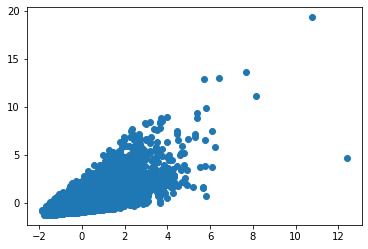

In [48]:
fig, ax = plt.subplots()

x = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df['price']


ax.scatter(x, y);

In [49]:
np.corrcoef(df['sqft_living'],df['price'])

array([[1.       , 0.7019173],
       [0.7019173, 1.       ]])

Passing our first assumption: Based on our scatterplot, we can see that there is a strong correlation between `sqft_living` and price. Our pearson correlation coefficiant of `.70` suggests that these two variables are strongly correlated. Refer to the heatmap above re: multicollinearity.

In [50]:
# Baseline model
# Import necessary package
from sklearn.dummy import DummyRegressor

# Instantiate
dummy_lr = DummyRegressor()

# Create variables
X = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df['price']

# Fit
dummy_lr.fit(X,y)

# Score
dummy_lr.score(X,y)

0.0

In [51]:
#Define X and y variable using scaled & parse dataframe

X_s_p = scaled_and_parse_df[['sqft_living']]
y_s_p = scaled_and_parse_df[['price']]

In [52]:
sk_lr = LinearRegression()
sk_lr.fit(X_s_p, y_s_p)
preds = sk_lr.predict(y_s_p)

preds

C:\Users\jsidd\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- price
Feature names seen at fit time, yet now missing:
- sqft_living

  warnings.warn(message, FutureWarning)


array([[-0.00774277],
       [-0.686163  ],
       [-0.06080357],
       ...,
       [-0.26925671],
       [-0.26527526],
       [-0.41138386]])

In [53]:
X = scaled_and_parse_df['sqft_living']
y = scaled_and_parse_df[['price']]

In [54]:
resids = y - preds
resids

,price
1,-0.00
2,-0.29
4,-0.03
5,0.55
7,-0.20
...,...
21590,0.38
21592,-0.15
21593,-0.11
21594,-0.11


In [55]:
#Create out bins

bins = int( len(X)**.5)
bins

120

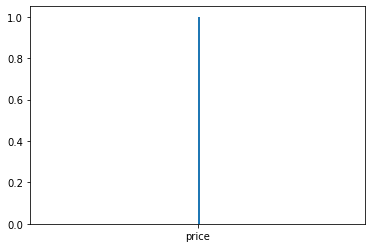

In [56]:
# Histogram of residuals

plt.hist(resids, bins=bins);

In [57]:
print(resids.max())
resids.min()

price   5.77
dtype: float64


price   -0.37
dtype: float64

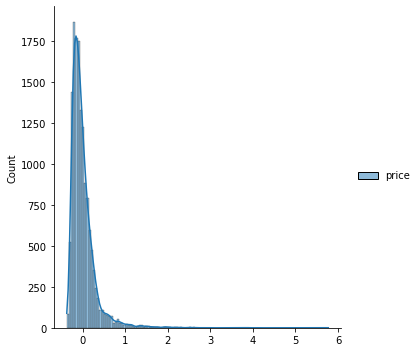

In [58]:
sns.displot(resids, bins=bins, kde=True)

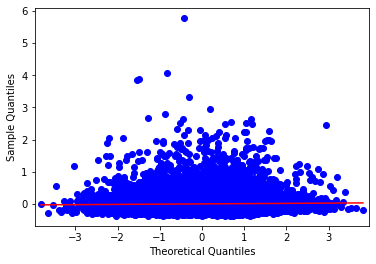

In [59]:
sm.qqplot(resids, line='r');

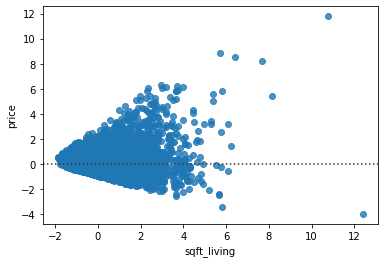

In [60]:
# resid plot sns.resid

sns.residplot(x=X, y=y);

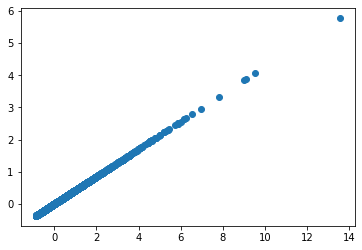

In [61]:
plt.scatter(preds, resids);

In [62]:
#Fit the dummy_regressor

dummy_lr.fit(X_s_p,y_s_p)

DummyRegressor()

In [63]:
# Score it

dummy_lr.score(X_s_p,y_s_p)

0.0

In [64]:
# Creating a straightforward, initial model --
# just for kicks
simple_formula = 'price ~ sqft_living'
simple_model = ols(formula = simple_formula,
                   data = scaled_and_parse_df).fit()
simple_mod_summ = simple_model.summary()

simple_mod_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 1.401e+04
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        08:44:45   Log-Likelihood:                -15630.
No. Observations:               14469   AIC:                         3.126e+04
Df Residuals:                   14467   BIC:                         3.128e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.152e-16      0.006   1.94e-14      1.000      -0.012       0.012
sqft_living     0.7015      0.006    118.383      0.000       0.690       0.713
==============================================================================
Omnibus:                     9406.447   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           265707.063
Skew:                           2.688   Prob(JB):                         0.00
Kurtosis:                      23.293   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#test on our test data set

Summary comparison between the two

#### Multiple regression | Rework to train data

Slowly adding in other variables

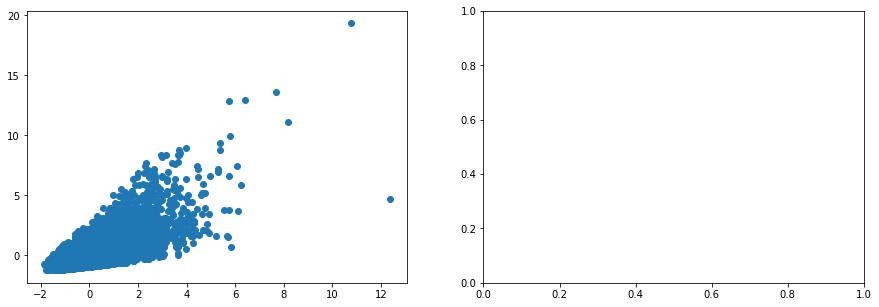

In [65]:
fig, ax = plt.subplots(ncols=2,figsize=(15,5))

x1 = scaled_and_parse_df[['sqft_living']]
y1 = scaled_and_parse_df[['price']]

# x2 = scaled_and_parse_df[['bedrooms']]

ax[0].scatter(x1, y1)
# ax[1].scatter(x2,y1);

#Upon looking at our scaled dataframe, we noticed that there is a house sold with 33 bedrooms for $600k
#After considering the price sold, sqft and number of bathrooms - the # of bedrooms appears 
#to be an error of somesort
#Since we explored bedrooms having a relatively small correlation to price, we are not too worried about this one
#outlier being included in our scatterplot

In [66]:
simple_formula3 = 'price ~ sqft_living'
simple_model3 = ols(formula = simple_formula3,
                   data = scaled_and_parse_df).fit()
simple_mod_summ3 = simple_model3.summary()

simple_mod_summ3

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 1.401e+04
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        08:44:54   Log-Likelihood:                -15630.
No. Observations:               14469   AIC:                         3.126e+04
Df Residuals:                   14467   BIC:                         3.128e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.152e-16      0.006   1.94e-14      1.000      -0.012       0.012
sqft_living     0.7015      0.006    118.383      0.000       0.690       0.713
==============================================================================
Omnibus:                     9406.447   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           265707.063
Skew:                           2.688   Prob(JB):                         0.00
Kurtosis:                      23.293   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [103]:
scaled_and_parse_df.head()

,sqft_living,price,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,view_FAIR,view_GOOD,view_NONE,view_nan
1,0.52,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
2,-1.42,-0.98,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,-0.44,-0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
5,3.60,1.86,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
7,-1.11,-0.68,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


In [107]:
simple_formula4 = 'price ~ sqft_living + view_FAIR + view_GOOD +view_NONE + grade_11_Excellent + grade_12_Luxury + grade_13_Mansion + grade_4_Low + grade_5_Fair + grade_6_Low_Average + grade_7_Average + grade_8_Good+ grade_9_Better'          

simple_model4 = ols(formula = simple_formula4,
                   data = scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     1841.
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:15:16   Log-Likelihood:                -13464.
No. Observations:               14468   AIC:                         2.696e+04
Df Residuals:                   14454   BIC:                         2.706e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.0239      0.045     44.943      0.000       1.936       2.112
sqft_living             0.3497      0.008     43.085      0.000       0.334       0.366
view_FAIR              -0.9613      0.043    -22.182      0.000      -1.046      -0.876
view_GOOD              -0.7289      0.050    -14.443      0.000      -0.828      -0.630
view_NONE              -1.2664      0.039    -32.652      0.000      -1.342      -1.190
grade_11_Excellent      0.7373      0.044     16.721      0.000       0.651       0.824
grade_12_Luxury         2.0550      0.083     24.768      0.000       1.892       2.218
grade_13_Mansion        6.3655      0.236     27.018      0.000       5.904       6.827
grade_4_Low            -1.1937      0.157     -7.600      0.000      -1.502      -0.886
grade_5_Fair           -1.1460      0.057    -20.079      0.000      -1.258      -1.034
grade_6_Low_Average    -1.0868      0.035    -31.485      0.000      -1.154      -1.019
grade_7_Average        -1.0075      0.029    -35.288      0.000      -1.063      -0.952
grade_8_Good           -0.8466      0.027    -31.453      0.000      -0.899      -0.794
grade_9_Better         -0.5279      0.027    -19.379      0.000      -0.581      -0.475
==============================================================================
Omnibus:                     7075.392   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           116120.981
Skew:                           1.947   Prob(JB):                         0.00
Kurtosis:                      16.322   Cond. No.                         67.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The above model has an adjusted R-squared value of 0.623 suggesting that this model accounts for roughly ~10-15% more variance.

In [108]:
simple_formula4 = 'price ~ view_FAIR + view_GOOD +view_NONE + grade_11_Excellent + grade_12_Luxury + grade_13_Mansion + grade_4_Low + grade_5_Fair + grade_6_Low_Average + grade_7_Average + grade_8_Good+ grade_9_Better'          

simple_model4 = ols(formula = simple_formula4,
                   data = scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     1630.
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:17:07   Log-Likelihood:                -14338.
No. Observations:               14468   AIC:                         2.870e+04
Df Residuals:                   14455   BIC:                         2.880e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.6907      0.045     59.897      0.000       2.603       2.779
view_FAIR              -1.0178      0.046    -22.120      0.000      -1.108      -0.928
view_GOOD              -0.7595      0.054    -14.170      0.000      -0.865      -0.654
view_NONE              -1.4082      0.041    -34.304      0.000      -1.489      -1.328
grade_11_Excellent      1.0371      0.046     22.422      0.000       0.946       1.128
grade_12_Luxury         2.7629      0.086     31.982      0.000       2.594       2.932
grade_13_Mansion        7.7849      0.248     31.415      0.000       7.299       8.271
grade_4_Low            -2.2558      0.165    -13.691      0.000      -2.579      -1.933
grade_5_Fair           -2.0901      0.056    -37.335      0.000      -2.200      -1.980
grade_6_Low_Average    -1.9561      0.030    -65.759      0.000      -2.014      -1.898
grade_7_Average        -1.6852      0.025    -66.589      0.000      -1.735      -1.636
grade_8_Good           -1.3450      0.026    -52.097      0.000      -1.396      -1.294
grade_9_Better         -0.7689      0.028    -27.149      0.000      -0.824      -0.713
==============================================================================
Omnibus:                     7944.405   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           164308.616
Skew:                           2.201   Prob(JB):                         0.00
Kurtosis:                      18.912   Cond. No.                         66.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
simple_formula4 = 'price ~ sqft_living + grade_11_Excellent + grade_12_Luxury + grade_13_Mansion + grade_4_Low + grade_5_Fair + grade_6_Low_Average + grade_7_Average + grade_8_Good+ grade_9_Better'          

simple_model4 = ols(formula = simple_formula4,
                   data = scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     2062.
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:17:58   Log-Likelihood:                -14117.
No. Observations:               14468   AIC:                         2.826e+04
Df Residuals:                   14457   BIC:                         2.834e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8551      0.027     32.032      0.000       0.803       0.907
sqft_living             0.3868      0.008     45.971      0.000       0.370       0.403
grade_11_Excellent      0.8067      0.046     17.509      0.000       0.716       0.897
grade_12_Luxury         2.2177      0.087     25.597      0.000       2.048       2.388
grade_13_Mansion        6.4756      0.246     26.282      0.000       5.993       6.959
grade_4_Low            -1.1974      0.164     -7.288      0.000      -1.519      -0.875
grade_5_Fair           -1.1827      0.060    -19.814      0.000      -1.300      -1.066
grade_6_Low_Average    -1.1274      0.036    -31.247      0.000      -1.198      -1.057
grade_7_Average        -1.0661      0.030    -35.763      0.000      -1.125      -1.008
grade_8_Good           -0.8966      0.028    -31.891      0.000      -0.952      -0.842
grade_9_Better         -0.5552      0.028    -19.492      0.000      -0.611      -0.499
==============================================================================
Omnibus:                     8084.288   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           152062.228
Skew:                           2.289   Prob(JB):                         0.00
Kurtosis:                      18.208   Cond. No.                         52.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
simple_formula4 = 'price ~ sqft_living + view_FAIR + view_GOOD +view_NONE'          

simple_model4 = ols(formula = simple_formula4,
                   data = scaled_and_parse_df).fit()

simple_mod_summ4 = simple_model4.summary()

simple_mod_summ4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     4226.
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:18:20   Log-Likelihood:                -14929.
No. Observations:               14468   AIC:                         2.987e+04
Df Residuals:                   14463   BIC:                         2.991e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.3648      0.042     32.342      0.000       1.282       1.447
sqft_living     0.6401      0.006    108.391      0.000       0.629       0.652
view_FAIR      -1.0743      0.048    -22.470      0.000      -1.168      -0.981
view_GOOD      -0.7806      0.056    -14.007      0.000      -0.890      -0.671
view_NONE      -1.4266      0.043    -33.399      0.000      -1.510      -1.343
==============================================================================
Omnibus:                     8781.255   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           261450.414
Skew:                           2.410   Prob(JB):                         0.00
Kurtosis:                      23.260   Cond. No.                         20.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It appears that our model is the strongest when we are comparing `sqft_living` + `view` + `grade` with an adjusted R-squared of 0.623.


## Next Steps:

- `bathrooms` and `bedrooms` - they are collinear with variables like `sqft_living`, which prevented us from including them in our model, but they might be useful avenues for further exploration.
- `waterfront` - our EDA demonstrated a significant difference in `price` between homes with waterfront views vs. homes without; it may be worth further exploring what development opportunities exist in waterfront areas.
- `zipcode` - taking a look at what neighborhoods/geographic areas yield high sale prices.
    - Look at interaction items: if homes with `EXCELLENT` views are concentrated in certain areas, perhaps.